# NOTES

### Task 1
Classify whether a loan will go into default or not

Should use 10-fold validation, and 15-20% of the data as test

Will use Neural Network, Ada Boosting, and SVM classifications

Need to include Visualizations - confusion matrices, bar chart of weighted factors, etc.

### Task 2
Use time series regression to predict monetary need for company in the next year

Use all but the final year of data as training to predict the final year as training model

Will use couple different types of ARMA, and maybe Vector Auto Regression (if in SAS)

Again need visualizations - confusion matrices, bar chart of weighted factors, etc.

#### Final Thoughts
Check the time to run each calculation via %timeit

Make sure to try various variables in each prediction model to get the best resuslts

See if there is a way to do stepwise or forward/backward search of features

To convert infinity to NAN, need to convert column to float and then can convert back as needed

# Mini Lab

## Brett Hallum, Mridul Jain, and Solomon Ndungu

We start this lab by filtering out our unwanted data. A lot of this information was removed in Lab 1 as it did not make sense for us to use it due to missing values, single values for whole set, and a minimal distribution of values. On top of this removal, we do some imputation to fill in minor missing data values. Finally, we do some nominal classification on some of our data to order it for better use.

We do create two additional data frames, loan_df_finished and loan_df_unfinished, at this point as well. Their purpose and usage will be discussed shortly.

In [1]:
import os
os.chdir('C:/Users/emrijai/Documents/IPython Notebooks/MS7331/Project1/MSDS7331_Project1')
os.getcwd()

'C:\\Users\\emrijai\\Documents\\IPython Notebooks\\MS7331\\Project1\\MSDS7331_Project1'

In [2]:
import pandas as pd
import numpy as np
import copy

import warnings
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter("ignore")

#Bring in data set
loan_df = pd.read_csv('LoanData/loanData_Small.csv')

#Remove unwanted attributes from the data set based on specific criteria
for col in ['id','funded_amnt_inv','sub_grade','emp_title','pymnt_plan','url','title','zip_code','earliest_cr_line',
            'mths_since_last_delinq','mths_since_last_record','pub_rec','revol_bal','revol_util',
            'initial_list_status','out_prncp_inv','total_pymnt_inv','recoveries','collection_recovery_fee',
            'last_pymnt_amnt','next_pymnt_d','last_credit_pull_d','collections_12_mths_ex_med','policy_code','application_type',
            'annual_inc_joint','dti_joint','verification_status_joint','open_acc_6m','open_il_6m','open_il_12m','open_il_24m',
            'mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util',
            'total_rev_hi_lim','inq_fi','total_cu_tl','inq_last_12m', 'mths_since_last_major_derog', 'desc', 'addr_state', 'tot_coll_amt', 'tot_cur_bal', 'member_id', 'total_rec_prncp', 'total_rec_int',
           'total_rec_late_fee', 'loan_amnt', 'out_prncp']:
    if col in loan_df:
        del loan_df[col]

#Create new variables for classification
#Modify term to be integer for easier analysis
loan_df = loan_df.replace(to_replace=" 36 months", value=36)
loan_df = loan_df.replace(to_replace=" 60 months", value=60)

#Impute missing data values with median
for col in ['annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'acc_now_delinq']:
    df_temp = copy.deepcopy(loan_df[col])
    df_temp = df_temp.replace(to_replace=np.nan, value=df_temp.median())
    loan_df[col] = df_temp
    
#Numerical classification of grade
tmp_df = pd.get_dummies(loan_df.grade,prefix='grade')
loan_df = pd.concat((loan_df,tmp_df),axis=1) # add back into the dataframe

if "grade" in loan_df:
    del loan_df["grade"]
    
#Numerical classification of employment length
tmp_df = pd.get_dummies(loan_df.emp_length,prefix='Employ')
loan_df = pd.concat((loan_df,tmp_df),axis=1) # add back into the dataframe

if "emp_length" in loan_df:
    del loan_df["emp_length"]

#Range of interest rates
loan_df['Int_Rate_Range'] = pd.cut(loan_df.int_rate, [0, 5,10,15,20,25, 30], 6, labels=[0, 1, 2, 3, 4, 5])

if "int_rate" in loan_df:
    del loan_df["int_rate"]

#Nominal classification of loan_status
loan_df.loc[loan_df['loan_status'] == 'Charged Off' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Default' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Late (31-120 days)' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Late (16-30 days)' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off' , 'Loan_Class'] = 0

loan_df.loc[loan_df['loan_status'] == 'Fully Paid' , 'Loan_Class'] = 1
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid' , 'Loan_Class'] = 1

loan_df.loc[loan_df['loan_status'] == 'Current' , 'Loan_Class'] = 1
loan_df.loc[loan_df['loan_status'] == 'In Grace Period' , 'Loan_Class'] = 1
loan_df.loc[loan_df['loan_status'] == 'Issued' , 'Loan_Class'] = 1

#Secondary classification of loan class for further analysis of data (used for new data frames)
# comparing the historical data (good/bad loans) to current data (loans still in progress)
# Loans are classified as 'Bad' if loans are bad
loan_df.loc[loan_df['loan_status'] == 'Charged Off' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Default' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Late (31-120 days)' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Late (16-30 days)' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off' , 'Loan_Class2'] = 'Bad'
# Loans are classified as 'Good' if loans are good
loan_df.loc[loan_df['loan_status'] == 'Fully Paid' , 'Loan_Class2'] = 'Good'
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid' , 'Loan_Class2'] = 'Good'
# Loans are classified as 'Current' if loans are current/still in progress
loan_df.loc[loan_df['loan_status'] == 'Current' , 'Loan_Class2'] = 'Current'
loan_df.loc[loan_df['loan_status'] == 'In Grace Period' , 'Loan_Class2'] = 'Current'
loan_df.loc[loan_df['loan_status'] == 'Issued' , 'Loan_Class2'] = 'Current'

if "loan_status" in loan_df:
    del loan_df["loan_status"]

#Nominal classification of verification status
loan_df.loc[loan_df['verification_status'] == 'Verified', 'Verify_Status'] = 1
loan_df.loc[loan_df['verification_status'] == 'Source Verified', 'Verify_Status'] = 1
loan_df.loc[loan_df['verification_status'] == 'Not Verified', 'Verify_Status'] = 0

if "verification_status" in loan_df:
    del loan_df["verification_status"]

#Nominal classification of home ownership
tmp_df = pd.get_dummies(loan_df.home_ownership,prefix='Home')
loan_df = pd.concat((loan_df,tmp_df),axis=1) # add back into the dataframe

if "home_ownership" in loan_df:
    del loan_df["home_ownership"]

#Impute missing data values with median
for col in ['total_acc']:
    df_temp = copy.deepcopy(loan_df[col])
    df_temp = df_temp.replace(to_replace=np.nan, value= 0 )
    loan_df[col] = df_temp    

for col in ['total_pymnt']:
    df_temp = copy.deepcopy(loan_df[col])
    df_temp = df_temp.replace(to_replace=np.nan, value= 0 )
    loan_df[col] = df_temp 
   

tmp_df = pd.get_dummies(loan_df.purpose,prefix='Loan_Purpose')
loan_df = pd.concat((loan_df,tmp_df),axis=1)

if 'purpose' in loan_df:
    del loan_df['purpose']
    
loan_df.head()

,funded_amnt,term,installment,annual_inc,issue_d,dti,delinq_2yrs,inq_last_6mths,open_acc,total_acc,...,Loan_Purpose_home_improvement,Loan_Purpose_house,Loan_Purpose_major_purchase,Loan_Purpose_medical,Loan_Purpose_moving,Loan_Purpose_other,Loan_Purpose_renewable_energy,Loan_Purpose_small_business,Loan_Purpose_vacation,Loan_Purpose_wedding
0,5000.0,36.0,162.87,24000.0,12/1/2011,27.65,0.0,1.0,3.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2500.0,60.0,59.83,30000.0,12/1/2011,1.00,0.0,5.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2400.0,36.0,84.33,12252.0,12/1/2011,8.72,0.0,2.0,2.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,10000.0,36.0,339.31,49200.0,12/1/2011,20.00,0.0,1.0,10.0,37.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3000.0,60.0,67.79,80000.0,12/1/2011,17.94,0.0,0.0,15.0,38.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [3]:
loan_df = loan_df.dropna()
print loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119991 entries, 0 to 120127
Data columns (total 55 columns):
funded_amnt                        119991 non-null float64
term                               119991 non-null float64
installment                        119991 non-null float64
annual_inc                         119991 non-null float64
issue_d                            119991 non-null object
dti                                119991 non-null float64
delinq_2yrs                        119991 non-null float64
inq_last_6mths                     119991 non-null float64
open_acc                           119991 non-null float64
total_acc                          119991 non-null float64
total_pymnt                        119991 non-null float64
last_pymnt_d                       119991 non-null object
acc_now_delinq                     119991 non-null float64
grade_A                            119991 non-null float64
grade_B                            119991 non-null float64
grade_

In [4]:
from datetime import datetime
loan_df['duration_paid'] =  (pd.to_datetime(loan_df['last_pymnt_d']) - pd.to_datetime(loan_df['issue_d']))

In [5]:
loan_df['Count_Days'] =  loan_df['duration_paid'].dt.days
loan_df['Payment_rate'] =  loan_df['total_pymnt'] / (loan_df['Count_Days']+1)*30
loan_df['Payment_ratio'] = loan_df['Payment_rate']/ loan_df['installment']

In [6]:
loan_df = loan_df.dropna()

In [7]:
if "issue_d" in loan_df:
    del loan_df["issue_d"]
if "last_pymnt_d" in loan_df:
    del loan_df["last_pymnt_d"]
if "total_pymnt" in loan_df:
    del loan_df["total_pymnt"]
if "duration_paid" in loan_df:
    del loan_df["duration_paid"]
if "Count_Days" in loan_df:
    del loan_df['Count_Days']

In [8]:
# Create separate data frames for future analysis and breakdown
loan_df_unfinished = loan_df[loan_df['Loan_Class2'] == 'Current'] #Data of uncompleted loans
loan_df_finished = loan_df[(loan_df['Loan_Class2'] == 'Bad') | (loan_df['Loan_Class2']=='Good')] #Data of completed loans

#loan_df.copy()

if "Loan_Class2" in loan_df:
    del loan_df["Loan_Class2"]

In [9]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119991 entries, 0 to 120127
Data columns (total 53 columns):
funded_amnt                        119991 non-null float64
term                               119991 non-null float64
installment                        119991 non-null float64
annual_inc                         119991 non-null float64
dti                                119991 non-null float64
delinq_2yrs                        119991 non-null float64
inq_last_6mths                     119991 non-null float64
open_acc                           119991 non-null float64
total_acc                          119991 non-null float64
acc_now_delinq                     119991 non-null float64
grade_A                            119991 non-null float64
grade_B                            119991 non-null float64
grade_C                            119991 non-null float64
grade_D                            119991 non-null float64
grade_E                            119991 non-null float64
grad

In [10]:
from sklearn.cross_validation import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

from matplotlib import pyplot as plt


# Split our data frame into our classification of Loan_Class and the rest of the data set
if 'Loan_Class' in loan_df:
    y = loan_df['Loan_Class'].values
    del loan_df['Loan_Class']
    X = loan_df.values

# Shuffle split our data into an 80/20 breakdown. The 80 will be used for training and the 20 for testing
num_cv_iterations = 5
num_instances = len(y)
cv_obj = ShuffleSplit(n = num_instances, n_iter = num_cv_iterations, test_size = 0.2)

print cv_obj

ShuffleSplit(119991, n_iter=5, test_size=0.2, random_state=None)


### Logistic Regression

We will begin by conducting a logistic regression on the full data set. We will look at the accuracy of the classification to see how accurate the regression model is and the confusion matrix to see if there are any oddities in the breakdown.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

logreg_obj = LogisticRegression(penalty='l2', C=1.0, class_weight=None)

# Fit and test the regression model for each shuffled instance
for iter_num, (train_indices, test_indices) in enumerate(cv_obj):
    logreg_obj.fit(X[train_indices],y[train_indices])  # train object
    y_hat = logreg_obj.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print "====Iteration",iter_num," ===="
    print "accuracy", mt.accuracy_score(y[test_indices],y_hat) 
    print "confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat)

====Iteration 0  ====
accuracy 0.873161381724
confusion matrix
[[    0  3044]
 [    0 20955]]
====Iteration 1  ====
accuracy 0.871077961582
confusion matrix
[[    0  3094]
 [    0 20905]]
====Iteration 2  ====
accuracy 0.871952998042
confusion matrix
[[    1  3073]
 [    0 20925]]
====Iteration 3  ====
accuracy 0.867702820951
confusion matrix
[[    0  3175]
 [    0 20824]]
====Iteration 4  ====
accuracy 0.873869744573
confusion matrix
[[    0  3027]
 [    0 20972]]


In [12]:
# Add column to determine if loan is good or bad based on classification in data set
loan_df_finished['isGoodLoan'] = loan_df_finished['Loan_Class2'] == 'Good'
loan_df_finished.isGoodLoan = loan_df_finished.isGoodLoan.astype(np.int)

#Remove Loan_Class and Loan_Class2 from the data frame so they are no longer observed for classification
if "Loan_Class" in loan_df_finished:
    del loan_df_finished["Loan_Class"]
if "Loan_Class2" in loan_df_finished:
    del loan_df_finished["Loan_Class2"]

In [13]:
# Split the data into our x and y matrices for testing
if 'isGoodLoan' in loan_df_finished:
    updated_y = loan_df_finished['isGoodLoan'].values
    del loan_df_finished['isGoodLoan']
    updated_X = loan_df_finished.values

# Create a new Shuffle split on the narrowed classification data
num_cv_iterations = 5
num_instances = len(updated_y)
updated_cv_obj = ShuffleSplit(n = num_instances, n_iter = num_cv_iterations, test_size = 0.2)

In [14]:
loan_df_finished.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78690 entries, 0 to 120127
Data columns (total 52 columns):
funded_amnt                        78690 non-null float64
term                               78690 non-null float64
installment                        78690 non-null float64
annual_inc                         78690 non-null float64
dti                                78690 non-null float64
delinq_2yrs                        78690 non-null float64
inq_last_6mths                     78690 non-null float64
open_acc                           78690 non-null float64
total_acc                          78690 non-null float64
acc_now_delinq                     78690 non-null float64
grade_A                            78690 non-null float64
grade_B                            78690 non-null float64
grade_C                            78690 non-null float64
grade_D                            78690 non-null float64
grade_E                            78690 non-null float64
grade_F             

In [15]:
updated_logreg_obj = LogisticRegression(penalty='l2', C=10, class_weight=None)

for iter_num, (train_indices, test_indices) in enumerate(updated_cv_obj):
    updated_logreg_obj.fit(updated_X[train_indices],updated_y[train_indices])  # train object
    updated_y_hat = updated_logreg_obj.predict(updated_X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print "==== Iteration",iter_num," ===="
    print "accuracy", mt.accuracy_score(updated_y[test_indices],updated_y_hat) 
    print "confusion matrix\n",mt.confusion_matrix(updated_y[test_indices],updated_y_hat)

==== Iteration 0  ====
accuracy 0.828694878638
confusion matrix
[[  627  2388]
 [  308 12415]]
==== Iteration 1  ====
accuracy 0.82462828822
confusion matrix
[[  616  2439]
 [  321 12362]]
==== Iteration 2  ====
accuracy 0.82704282628
confusion matrix
[[  614  2429]
 [  293 12402]]
==== Iteration 3  ====
accuracy 0.820688778752
confusion matrix
[[  580  2539]
 [  283 12336]]
==== Iteration 4  ====
accuracy 0.827296988181
confusion matrix
[[  642  2368]
 [  350 12378]]


The results of this classification not only have a higher accuracy than the original, full data set, right around 97.9% on average rather than 93.1%, but it also has better looking confusion mattrices. There are data points that are classified correctly. Although there are still a large number of bad loans being incorrectly identified as good, it is much better distributed than the original set.

We follow up this analysis by looking at the weight of each factor used. This will help us figure out if there are certain features that are more influential than others to help with the classification of each point.

In [16]:
# Non-normalized weights
# Iterate over the coefficients to get the weight for each variable
weights = updated_logreg_obj.coef_.T # take transpose to make a column vector
variable_names = loan_df_finished.columns
for coef, name in zip(weights,variable_names):
    print name, 'has weight of', coef[0]

funded_amnt has weight of -0.000246177271187
term has weight of 0.0154134407877
installment has weight of 0.000488716048863
annual_inc has weight of 1.11391807371e-05
dti has weight of 0.00264371557629
delinq_2yrs has weight of -0.000191555413752
inq_last_6mths has weight of -0.000328872081796
open_acc has weight of 0.00268786243907
total_acc has weight of 0.00686944009792
acc_now_delinq has weight of -7.74550672785e-06
grade_A has weight of 0.000758107916881
grade_B has weight of 0.00052775514859
grade_C has weight of -2.48922144832e-05
grade_D has weight of -0.000216620135025
grade_E has weight of -0.000184715112781
grade_F has weight of -0.000144100596558
grade_G has weight of -4.18882392495e-05
Employ_1 year has weight of 8.79305077563e-05
Employ_10+ years has weight of -4.14595821805e-05
Employ_2 years has weight of 0.00013883503275
Employ_3 years has weight of 0.000124673059859
Employ_4 years has weight of 0.000100125048952
Employ_5 years has weight of 7.55581836664e-05
Employ_6 

We want to normalize the weights for each variable so that a much larger valued variable, such as the funded amount, is weighted the same as a small valued variable such as one that is binary or nominal.

Home_OTHER has weight of 0.000397427002215
Loan_Purpose_renewable_energy has weight of 0.000960838278647
Home_RENT has weight of 0.00177672666076
Loan_Purpose_vacation has weight of 0.00200346569907
Loan_Purpose_medical has weight of -0.00242403185564
Loan_Purpose_moving has weight of 0.00323443900007
Home_NONE has weight of -0.00435688595927
Loan_Purpose_debt_consolidation has weight of -0.00579566782653
Home_MORTGAGE has weight of 0.00772828015904
Employ_9 years has weight of -0.00895489779833
Loan_Purpose_home_improvement has weight of 0.00950591529707
Loan_Purpose_other has weight of -0.0102198521342
Loan_Purpose_house has weight of 0.0114797949884
Employ_7 years has weight of -0.0117572911304
Employ_6 years has weight of -0.0129085518948
Loan_Purpose_educational has weight of -0.0140209772964
Employ_1 year has weight of 0.0141878727607
Home_OWN has weight of -0.0171496258425
Employ_5 years has weight of 0.017413077837
Loan_Purpose_credit_card has weight of -0.0204247532141
Employ_

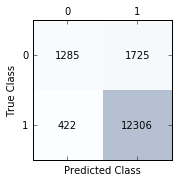

In [17]:
warnings.simplefilter("ignore")
%matplotlib inline

# Normalize the features
scale_obj = StandardScaler()
scale_obj.fit(updated_X[train_indices])

X_train_scaled = scale_obj.transform(updated_X[train_indices]) # apply to training
X_test_scaled = scale_obj.transform(updated_X[test_indices])

# Fit the regression to the new scaled data
updated_logreg_obj.fit(X_train_scaled, updated_y[train_indices])

y_hat = updated_logreg_obj.predict(X_test_scaled)

# Rescore the accuracy and confusion matrix for the scaled data
acc = mt.accuracy_score(updated_y[test_indices],y_hat)
conf = mt.confusion_matrix(updated_y[test_indices],y_hat)


# Sort the attributes on size and print them out in order of weight
zip_vars = zip(updated_logreg_obj.coef_.T,loan_df_finished.columns) # combine attributes
zip_vars.sort(key = lambda t: np.abs(t[0])) # sort them by the magnitude of the weight
for coef, name in zip_vars:
    print name, 'has weight of', coef[0] # now print them out
    
fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(conf, cmap=plt.cm.Blues, alpha = 0.3)
for i in range (conf.shape[0]):
    for j in range (conf.shape[1]):
        ax.text(x=j, y=i, s=conf[i, j], va = 'center', ha = 'center')
plt.xlabel ('Predicted Class')
plt.ylabel ('True Class')
plt.show

print 'accuracy:', acc

After scaling the data, we still get a similar accuracy to before and our confusion matrix has remained proportional. The scaled view of the variables provides a better way to compare each of the variables to one another and see which have a significant impact. In the graph below, it is even easier to note which variables have the most impact. The funded amount and total payment variables have a significant impact over any of the rest of the variables. Other notable variables that are valued slightly higher than the other factors are the Interst Rate Range, annual income and the number of total accounts someone has.

These values make a lot of sense as to why they are the most important. The total payment should definitely be a factor that plays into determining if a loan is good or bad. If the loan is in good standing, the full principle amount will be paid off. This will relate positively because as you pay more back to the bank, you will become closer to finishing the loan. Alternatively, the less money you have paid the more likely you are to default on the loan. Funded amount and interest rate range are also valuable. Banks probably use these in relation to one another to determine who will default and give certain rates for ceratin funded amounts. They are negatively weighted in this case which means the higher the interest rate and the higher the funded amount, the more likely someone is to default. As a loan increases in value and interest rate, it gets more difficult to pay off the loan and so someone is more likely to go into default and end up with a "bad" loan.

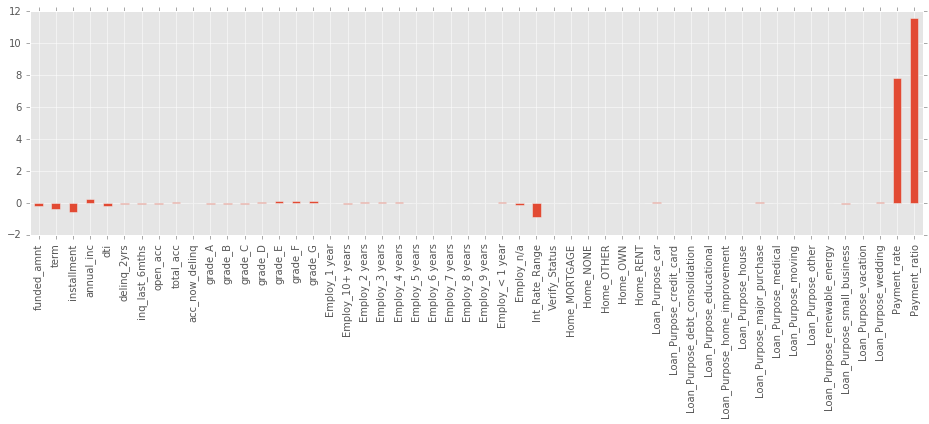

In [18]:
# now let's make a pandas Series with the names and values, and plot them

%matplotlib inline
plt.style.use('ggplot')
fig = plt.figure(figsize=(16, 4))

weights = pd.Series(updated_logreg_obj.coef_[0],index=loan_df_finished.columns)
weights.plot(kind='bar')
plt.show()

### Support Vector Machines

We continue our trials by observing the Support Vector Machines (SVM) to see if this method of classification can classify our data set better than logistic regression. We will start by observing the SVM of our original data set. Although it will most likely turn out the same way, not giving very good data, the SVM may reveal new splits in the decision. We will follow that up with looking at the SVM of the reduced data set that contains the completed loans. We can compare the accuracy of the SVM with the above logistic regression to determine if one classifies this data better than the other.

Note: We use the SGDClassifier due to the size of our data set. Both sets are large and would take too long to train with a normal SVM in a time that is reasonable.

SVM: 0.875828159507
Confusion Matrix:
[[    0  2980]
 [    0 21019]]
Coefficients [[  3.11550362e-04  -3.11015037e-04  -3.00446352e-04   1.01377016e-04
   -5.55860113e-05  -8.20095644e-05   9.18510357e-05  -3.27614469e-04
   -1.42746684e-04   3.56534288e-04   3.10714842e-04  -1.53643261e-05
   -4.30783595e-05   4.43464091e-05  -2.18949869e-04  -1.37505337e-05
   -5.00854569e-04  -4.38257122e-07   1.73848588e-04   3.22812410e-05
    9.07831991e-05   1.33680047e-04   1.35504275e-05  -2.72136382e-04
    2.21751078e-05  -2.23844821e-04  -7.06659124e-05  -5.71900014e-05
   -7.64268252e-05  -1.54388661e-04   4.68026254e-05   4.15975784e-05
   -2.05732556e-03   2.38551071e-04  -1.00234849e-04   3.58639786e-05
    6.54756250e-05   4.11149085e-05  -1.34610554e-04   6.30506936e-06
   -1.83227622e-04   3.50813165e-04   5.12264466e-05  -7.04652486e-06
    7.33423610e-05   4.93427921e-05   1.57268834e-04   8.19007245e-05
   -1.70302243e-04   2.54858229e-04   2.66863606e-04   2.61714039e-03]]


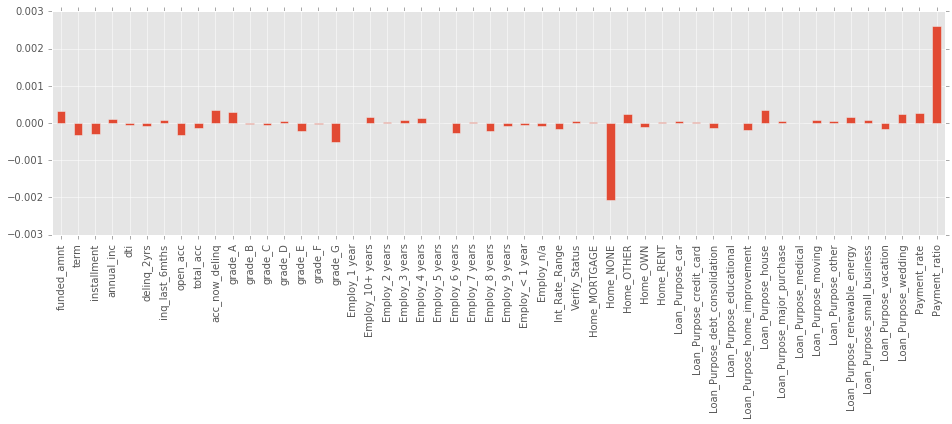

In [19]:
# SVM of full data set
warnings.simplefilter("ignore")

# SGDClassifier using 'hinge' for loss to get an SVM
from sklearn.linear_model import SGDClassifier

# Get SVM classifier
regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter=iterations, n_jobs=-1, penalty='l2')

# Fit our data (after it is scaled) to an SVM classification
scl = StandardScaler()
for train_idx, test_idx in cv_obj:
    svm_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print 'SVM:', acc
print 'Confusion Matrix:\n', conf
print 'Coefficients', svm_sgd.coef_
weights = pd.Series(svm_sgd.coef_[0],index=loan_df_finished.columns)
weights.plot(kind='bar', figsize=(16,4))

The accuracy of the full data set remained very similar. It stayed at around 93% accuracy, but still has the same style of confusion matrix from the logistic regression with bad loans being classified as good ones. We now look at the SVM of the reduced data to see how it performs.

SVM: 0.804231795654
Confusion Matrix:
[[    0  3081]
 [    0 12657]]
Coefficients [[ -4.81310455e-03  -5.73028647e-03  -3.89063449e-03   3.84099512e-03
   -1.65318157e-03  -6.71902892e-04  -9.21159311e-04  -1.70905760e-03
    1.51771630e-03  -1.42174334e-04  -2.60156483e-03   7.17487521e-05
    1.14633480e-04   7.10412837e-04   7.38825294e-04   1.36021191e-03
    2.36601134e-03   2.51872301e-04  -8.79034662e-04   1.02078957e-03
    7.98485252e-04   6.19171395e-05  -6.75012790e-04  -8.25366025e-04
   -3.35863917e-04  -6.29302264e-05   4.36788145e-04   4.96419996e-04
    3.26666528e-05  -1.07048729e-02   6.02827801e-05  -4.98561112e-04
    1.47412789e-04   5.71372237e-04  -7.89543789e-05   4.95895715e-04
    1.05488153e-03  -1.81776851e-04  -7.71343195e-05   2.06853628e-04
    6.78965844e-05  -6.36174136e-04   6.28129077e-04  -1.19957968e-04
    5.22818987e-04  -7.50388541e-04   1.36975491e-03  -1.16279287e-03
    7.77148371e-04   8.32675001e-04   6.51680808e-02   6.82483719e-02]]


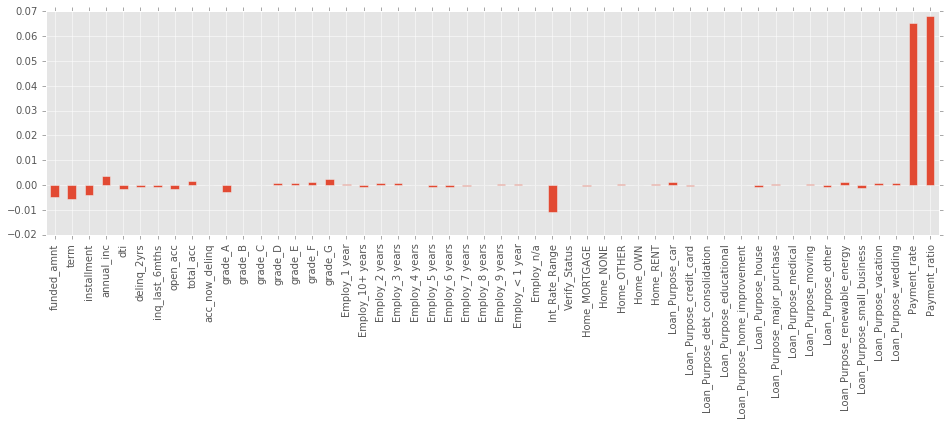

In [20]:
# SGDClassifier using 'hinge' for loss to get an SVM
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in updated_cv_obj:
    svm_sgd.fit(scl.fit_transform(updated_X[train_idx]),updated_y[train_idx])
    yhat = svm_sgd.predict(scl.transform(updated_X[test_idx]))
    
    conf = mt.confusion_matrix(updated_y[test_idx],yhat)
    acc = mt.accuracy_score(updated_y[test_idx],yhat)

print 'SVM:', acc
print 'Confusion Matrix:\n', conf
print 'Coefficients', svm_sgd.coef_
weights = pd.Series(svm_sgd.coef_[0],index=loan_df_finished.columns)
weights.plot(kind='bar', figsize=(16,4))

The SVM for the reduced data, which includes just completed loans, has a much lower accuracy than the logistic regression classification of the same data. The accuracy dropped from just below 98.0% to around 86.8%. This is a significant difference. It is possible that part of this is due to SGDClassifier taking the Stochastic Gradient instead of the full gradient of the SVM. Although the SGD runs faster than the linear regression model we used (LinearRegression()), it does not have the accuracy that we would expect or want in this situation, especially when the original data stayed around the same accuracy between the two different classifications.

It is interesting to note that the classes that the SVM pulls out are almost identical to the ones the logistic regression uses. Funded amount and total payment are still at the top of the list with Interest Rate Range being a distant fourth, but still near the top. Surprisingly, it has added importance on the 'Term' variable that the logistic regression did not pull out.

### Additional Analysis: Are there better parameter or variable choices?

As suggested by the Batch SVM previously, it looks like there might be better parameter set that can help us generage the best Bias-variance trade-off. In this section, we want to see if we can improve the overall accuracy of our model by adjusting the parameters we pass into our Logistic Regression and SVM models and by reducing the number of variables we look at with our model. Either of these changes could lead to better performance in both accuracy and the confusion mattrices.

Overfitting is a common problem in machine learning, where a model performs well on training data but does not generalize well to unseen data (test data). If a model suffers from overfitting, we also say that the model has a high variance, which can be caused by having too many parameters that lead to a model that is too complex given the underlying data. Similarly, our model can also suffer from underfitting (high bias), which means that our model is not complex enough to capture the pattern in the training data well and therefore also suffers from low performance
on unseen data. There are various parameters for finding a good bias-variance tradeoff and to tune the complexity of the model via regularization. 

Cost Function 'C' : A large C gives you low bias and high variance. Low bias because you penalize the cost of missclasification a lot. A small C gives you higher bias and lower variance. A lower C means higher regularization. A lower C thus prevents overfitting.

L1/L2 Regularization : L2 regularization (sometimes also called L2 shrinkage or weight decay) or L1 regularization where penalty is the sum of the absolute weight coefficients while in L2 that term is quadratic)

Below we will try to change the model parameters and try find the optimal values for these parameters.

Please note that both SVC and LinearSVC have the regularization hyperparameter C, but the SGDClassifier has the regularization hyperparameter alpha. Where C = n_samples / alpha

### Analysis 1: Changing Model Parameters

In [34]:
# Changing SVM Model Parameters - can alter penalty, L1 ratio and alpha

for val in range(6):
    print "======= L1 Penalty with alpha =", 10**(-val), "========"
    regularize_const = 10**(-val)
    iterations = 6
    svm_sgd = SGDClassifier(alpha=regularize_const,
            fit_intercept=True, l1_ratio=1, learning_rate='optimal',
            loss='hinge', n_iter=iterations, n_jobs=-1, penalty='L1')

    scl = StandardScaler()
    for train_idx, test_idx in updated_cv_obj:
        svm_sgd.fit(scl.fit_transform(updated_X[train_idx]),updated_y[train_idx])
        yhat = svm_sgd.predict(scl.transform(updated_X[test_idx]))

        conf = mt.confusion_matrix(updated_y[test_idx],yhat)
        acc = mt.accuracy_score(updated_y[test_idx],yhat)

    print 'SVM:', acc
    print 'Confusion Matrix:\n', conf
    
for val in range(6):
    print "======= L1 Penalty with l1_ratio =", (val/4.0), "========"
    regularize_const = 0.0001
    iterations = 6
    svm_sgd = SGDClassifier(alpha=regularize_const,
            fit_intercept=True, l1_ratio=val/4, learning_rate='optimal',
            loss='hinge', n_iter=iterations, n_jobs=-1, penalty='L1')

    scl = StandardScaler()
    for train_idx, test_idx in updated_cv_obj:
        svm_sgd.fit(scl.fit_transform(updated_X[train_idx]),updated_y[train_idx])
        yhat = svm_sgd.predict(scl.transform(updated_X[test_idx]))

        conf = mt.confusion_matrix(updated_y[test_idx],yhat)
        acc = mt.accuracy_score(updated_y[test_idx],yhat)

    print 'SVM:', acc
    print 'Confusion Matrix:\n', conf
    
for val in range(6):
    print "======= L2 Penalty with alpha =", 10**(-val), "========"
    regularize_const = 10**(-val)
    iterations = 6
    svm_sgd = SGDClassifier(alpha=regularize_const,
            fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
            loss='hinge', n_iter=iterations, n_jobs=-1, penalty='L2')

    scl = StandardScaler()
    for train_idx, test_idx in updated_cv_obj:
        svm_sgd.fit(scl.fit_transform(updated_X[train_idx]),updated_y[train_idx])
        yhat = svm_sgd.predict(scl.transform(updated_X[test_idx]))

        conf = mt.confusion_matrix(updated_y[test_idx],yhat)
        acc = mt.accuracy_score(updated_y[test_idx],yhat)

    print 'SVM:', acc
    print 'Confusion Matrix:\n', conf

======= L1 Penalty with alpha = 1 ========
SVM: 0.804867200407
Confusion Matrix:
[[    0  3071]
 [    0 12667]]
======= L1 Penalty with alpha = 0.1 ========
SVM: 0.803088067099
Confusion Matrix:
[[    0  3099]
 [    0 12639]]
======= L1 Penalty with alpha = 0.01 ========
SVM: 0.80562968611
Confusion Matrix:
[[    0  3059]
 [    0 12679]]
======= L1 Penalty with alpha = 0.001 ========
SVM: 0.845215402211
Confusion Matrix:
[[  796  2271]
 [  165 12506]]
======= L1 Penalty with alpha = 0.0001 ========
SVM: 0.849472614055
Confusion Matrix:
[[  906  2123]
 [  246 12463]]
======= L1 Penalty with alpha = 1e-05 ========
SVM: 0.82799593341
Confusion Matrix:
[[ 1438  1610]
 [ 1097 11593]]
======= L1 Penalty with l1_ratio = 0.0 ========
SVM: 0.842165459398
Confusion Matrix:
[[  803  2291]
 [  193 12451]]
======= L1 Penalty with l1_ratio = 0.25 ========
SVM: 0.835430169018
Confusion Matrix:
[[  629  2519]
 [   71 12519]]
======= L1 Penalty with l1_ratio = 0.5 ========
SVM: 0.856462066336
Confusion

The unscaled data of this significantly reduced data set has a marginally better fit than the original reduced data set. If you compare the 98.1% average of the newly reduced data set to the 97.9% of the base reduced data, you get a slightly better performance by taking out some of the less important, according to the logistic regression, variables. The scaled data comes in at a similar accuracy rating of the original sample at 97.9% so there really is not a huge change here. Even looking at the weights of each, the funded amount and total payment factors still far outweigh the others.

### Analysis 2: Reduced Number of Factors
In this section, we will use the logistic regression classification, which seemed to perform better for our reduced data set, to see if we can increase the accuracy of our model by looking at different variable inputs. The idea is to reduce the number of inputs to try and improve the data. What if we look at our major regression factors and limit our dataset to those factors? Do we improve accuracy any by limiting the data given to the classifier?

In [22]:
used_temp_df = pd.DataFrame()
major_factors_df = loan_df_finished

for col in ['funded_amnt', 'Int_Rate_Range' , 'Payment_rate' , 'Payment_ratio', 'annual_inc', 'Verify_Status']:
    if col in major_factors_df:
        used_temp_df[col] = major_factors_df[col]
        
updated_X = used_temp_df.values

updated_logreg_obj = LogisticRegression(penalty='l2', C=1.0, class_weight=None)

for iter_num, (train_indices, test_indices) in enumerate(updated_cv_obj):
    updated_logreg_obj.fit(updated_X[train_indices],updated_y[train_indices])  # train object
    updated_y_hat = updated_logreg_obj.predict(updated_X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print "====Iteration",iter_num," ===="
    print "accuracy", mt.accuracy_score(updated_y[test_indices],updated_y_hat) 
    print "confusion matrix\n",mt.confusion_matrix(updated_y[test_indices],updated_y_hat)

====Iteration 0  ====
accuracy 0.822150209684
confusion matrix
[[  795  2306]
 [  493 12144]]
====Iteration 1  ====
accuracy 0.822023128733
confusion matrix
[[  827  2301]
 [  500 12110]]
====Iteration 2  ====
accuracy 0.823992883467
confusion matrix
[[  805  2301]
 [  469 12163]]
====Iteration 3  ====
accuracy 0.824818909645
confusion matrix
[[  798  2268]
 [  489 12183]]
====Iteration 4  ====
accuracy 0.824501207269
confusion matrix
[[  789  2285]
 [  477 12187]]


accuracy: 0.851505909264
[[ 1170  1904]
 [  433 12231]]


<function matplotlib.pyplot.show>

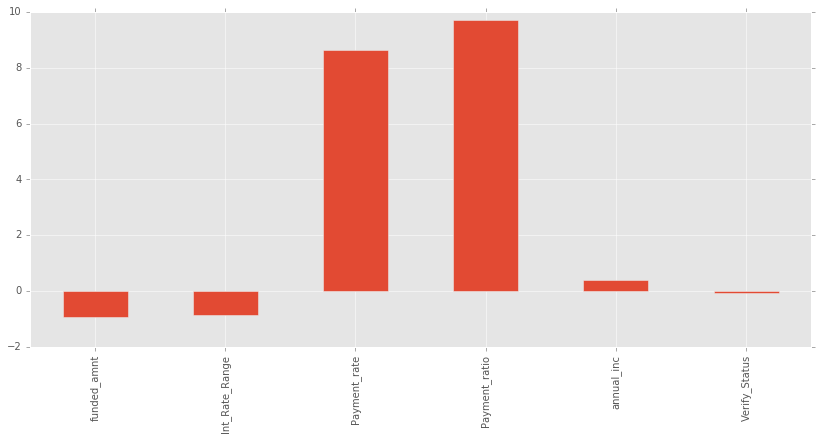

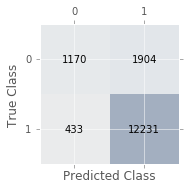

In [23]:
scl = StandardScaler()
scl.fit(updated_X[train_indices])

X_train_scaled = scl.transform(updated_X[train_indices]) # apply to training
X_test_scaled = scl.transform(updated_X[test_indices])

# Fit the regression to the new scaled data
updated_logreg_obj.fit(X_train_scaled, updated_y[train_indices])

y_hat = updated_logreg_obj.predict(X_test_scaled)

# Rescore the accuracy and confusion matrix for the scaled data
acc = mt.accuracy_score(updated_y[test_indices],y_hat)
conf = mt.confusion_matrix(updated_y[test_indices],y_hat)
print 'accuracy:', acc 
print conf
weights = pd.Series(updated_logreg_obj.coef_[0],index=used_temp_df.columns)
weights.plot(kind='bar', figsize=(14,6))

fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(conf, cmap=plt.cm.Blues, alpha = 0.3)
for i in range (conf.shape[0]):
    for j in range (conf.shape[1]):
        ax.text(x=j, y=i, s=conf[i, j], va = 'center', ha = 'center')
plt.xlabel ('Predicted Class')
plt.ylabel ('True Class')
plt.show

In [35]:
from sklearn.learning_curve import validation_curve
from sklearn.preprocessing import  StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

pipe_svc = Pipeline([('scl', StandardScaler()), ('clf', SVC(random_state=1))])

param_range = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = [{'clf__C': param_range, 'clf__kernel': ['linear']}]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring = 'accuracy', cv=10, n_jobs=-1)
gs = gs.fit(updated_X[train_indices],updated_y[train_indices])

print (gs.best_score_)
print (gs.best_params_)

0.848011183124
{'clf__C': 10, 'clf__kernel': 'linear'}
